# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
from scipy.signal import butter, filtfilt

from utility import read_all_csvs_one_test
from utility import read_all_test_data_from_path
from utility import read_all_test_data_from_path, show_reg_result,extract_selected_feature, prepare_sliding_window, FaultDetectReg

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_regression


Read data and pre_processing

In [2]:
n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    # Function to design a Butterworth low-pass filter
    def butter_lowpass(cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a


    # Function to apply the Butterworth low-pass filter
    def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
        b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
        filtered_data = filtfilt(b, a, data)
        return filtered_data


    # Set parameters for the low-pass filter
    cutoff_frequency = .8  # Adjust as needed
    sampling_frequency = 10  # Assuming your data is evenly spaced in time


    def customized_outlier_removal(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].ffill()
        df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
        df['position'] = df['position'].rolling(window=20, min_periods=1).mean()
        df['position'] = df['position'].round()

        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].rolling(window=20, min_periods=1).mean()

        # Make sure that the difference between the current and previous temperature cannot be too large.
        # Define your threshold
        threshold = 5
        # Shift the 'temperature' column by one row to get the previous temperature
        prev_tmp = df['temperature'].shift(1)
        # Calculate the absolute difference between current and previous temperature
        temp_diff = np.abs(df['temperature'] - prev_tmp)
        # Set the temperature to NaN where the difference is larger than the threshold
        df.loc[temp_diff > threshold, 'temperature'] = np.nan
        df['temperature'] = df['temperature'].ffill()

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
        df['voltage'] = df['voltage'].ffill()
        df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
        df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df, n_int)

base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [3]:
# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, pre_processing)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

In [4]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]

In [4]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Steps for Linear Regression
linear_regression_steps = [
    ('Normalizer', MinMaxScaler()),  # Step 1: Normalization
    #('Standardizer', StandardScaler),  # Step 1: Standardization
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Steps for Ridge Regression
ridge_regression_steps = [
    ('Normalizer', MinMaxScaler()),  # Step 1: Normalization
    #('Standardizer', StandardScaler),  # Step 1: Standardization
    ('regressor', Ridge())               # Step 2: Ridge Regression
]

# Steps for Lasso Regression
lasso_regression_steps = [
    ('Normalizer', MinMaxScaler()),  # Step 1: Normalization
    #('Standardizer', StandardScaler),  # Step 1: Standardizatio
    ('regressor', Lasso())               # Step 2: Lasso Regression
]

# Steps for ElasticNet Regression
elasticnet_regression_steps = [
    ('Normalizer', MinMaxScaler()),  # Step 1: Normalization
    #('Standardizer', StandardScaler),  # Step 1: Standardization
    ('regressor', ElasticNet())          # Step 2: ElasticNet Regression
]

# Steps for Decision Tree Regression
decision_tree_steps = [
    ('regressor', DecisionTreeRegressor())  # Step 2: Decision Tree Regressor
]

# Initialize Pipelines for each model
mdl_linear_regression = Pipeline(linear_regression_steps)
mdl_ridge_regression = Pipeline(ridge_regression_steps)
mdl_lasso_regression = Pipeline(lasso_regression_steps)
mdl_elasticnet_regression = Pipeline(elasticnet_regression_steps)
mdl_decision_tree = Pipeline(decision_tree_steps)

# List of models to be used in GridSearchCV
models = [
    ('Linear Regression', mdl_linear_regression),
    ('Ridge Regression', mdl_ridge_regression),
    ('Lasso Regression', mdl_lasso_regression),
    ('ElasticNet Regression', mdl_elasticnet_regression),
    ('Decision Tree Regression', mdl_decision_tree),
]


In [5]:
from utility import run_cv_one_motor


def run_all_motors(df_data, mdl, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
            prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cv_one_motor(motor_idx=i, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, mdl_type=mdl_type)
        all_results.append(df_perf)

    return all_results

In [6]:
def run_all_models_motor6(df_data, models, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
                   prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    summary_results = []
    for name, mdl in models:
        print(f'Running model: {name}')
        df_perf  = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, mdl_type=mdl_type)
        
        summary_results.append((name, df_perf))
    
    return summary_results

def run_all_models_motor5(df_data, models, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
                   prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    summary_results = []
    for name, mdl in models:
        print(f'Running model: {name}')
        df_perf  = run_cv_one_motor(motor_idx=5, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, mdl_type=mdl_type)
        
        summary_results.append((name, df_perf))
    
    return summary_results


def run_all_models(df_data, models, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
                   prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    summary_results = []
    for name, mdl in models:
        print(f'Running model: {name}')
        all_results = run_all_motors(df_data, mdl, feature_list, n_fold=n_fold, threshold=threshold, 
                                     window_size=window_size, sample_step=sample_step,
                                     prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, 
                                     mdl_type=mdl_type)
        
        df_all_results = pd.concat(all_results, keys=[f'Motor_{i}' for i in range(1, 7)])
        summary_results.append((name, df_all_results))
    
    return summary_results

Select Features

In [8]:
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature','data_motor_1_voltage',
       'data_motor_1_temperature_diff', 'data_motor_1_voltage_diff','data_motor_1_position_diff', 
       'data_motor_2_position','data_motor_2_temperature', 'data_motor_2_voltage', 
       'data_motor_2_temperature_diff', 'data_motor_2_voltage_diff', 'data_motor_2_position_diff',
       'data_motor_3_position', 'data_motor_3_temperature','data_motor_3_voltage',
       'data_motor_3_temperature_diff', 'data_motor_3_voltage_diff','data_motor_3_position_diff', 
       'data_motor_4_position','data_motor_4_temperature', 'data_motor_4_voltage',
       'data_motor_4_temperature_diff', 'data_motor_4_voltage_diff', 'data_motor_4_position_diff',
       'data_motor_5_position', 'data_motor_5_temperature','data_motor_5_voltage',
       'data_motor_5_temperature_diff', 'data_motor_5_voltage_diff','data_motor_5_position_diff', 
       'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
       'data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']


selected_features= ['time','data_motor_1_position',  'data_motor_1_temperature', 
                    'data_motor_2_position',  
                    'data_motor_3_position',  
                    'data_motor_4_position', 'data_motor_4_temperature',
                    'data_motor_5_position', 'data_motor_5_temperature',
                    'data_motor_6_position', 'data_motor_6_temperature', 
                    'data_motor_1_voltage']

threshold = 1
window_size = 1
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

#all_model_results = run_all_models(df_data=df_data_smoothing, models=models, feature_list=selected_features, threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

all_model_results = run_all_models(df_data=df_data_smoothing, models=models, feature_list=selected_features, threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

Running model: Linear Regression
Model for predicting temperature of motor 1:
Model for motor 1:
   Max error       RMSE  Exceed boundary rate
0  18.561360   8.434151              0.907702
1   9.379152   2.406074              0.807183
2  34.791890  22.018340              0.961836
3  14.205442   5.826287              0.752688
4  23.378524  13.316468              0.991731


Mean performance metric and standard error:
Max error: 20.0633 +- 9.7294
RMSE: 10.4003 +- 7.6187
Exceed boundary rate: 0.8842 +- 0.1017


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   4.587556  1.791137              0.628756
1   8.756402  1.882761              0.323251
2   7.581748  4.428876              0.794304
3   2.304885  0.904167              0.241935
4   3.501288  1.069757              0.294743


Mean performance metric and standard error:
Max error: 5.3464 +- 2.7320
RMSE: 2.0153 +- 1.4161
Exceed boundary rate: 0.4566 +- 0.2417


Model for predi

In [9]:
summary_data = {
    'Model': [],
    'Max error': [],
    'RMSE': [],
    'Exceed boundary rate': []
}

for model_name, df_results in all_model_results:
    max_error = df_results['Max error'].mean()
    mse = df_results['RMSE'].mean()
    exceed_boundary_rate = df_results['Exceed boundary rate'].mean()
    
    summary_data['Model'].append(model_name)
    summary_data['Max error'].append(f'{max_error:.2f}')
    summary_data['RMSE'].append(f'{mse:.2f}')
    summary_data['Exceed boundary rate'].append(f'{exceed_boundary_rate:.2f}')

summary_df = pd.DataFrame(summary_data)

print("Summary of the results - Only using features from the current moment\n")
print("| Model                   | Max error | RMSE  | Exceed boundary rate |")
print("|-------------------------|-----------|-------|----------------------|")

for model_name, df_results in all_model_results:
    max_error = df_results['Max error'].mean()
    mse = df_results['RMSE'].mean()
    exceed_boundary_rate = df_results['Exceed boundary rate'].mean()
    
    print(f"| {model_name.ljust(24)} | {max_error:8.2f} | {mse:6.2f} | {exceed_boundary_rate:6.2f} |")

best_model = summary_df.loc[summary_df['RMSE'].idxmin()]
print(f"\nThe best model is {best_model['Model']} with a Mean Squared Error (RMSE) of {best_model['RMSE']}.")

Summary of the results - Only using features from the current moment

| Model                   | Max error | RMSE  | Exceed boundary rate |
|-------------------------|-----------|-------|----------------------|
| Linear Regression        |    11.34 |   4.77 |   0.68 |
| Ridge Regression         |    11.23 |   4.73 |   0.68 |
| Lasso Regression         |     6.93 |   3.35 |   0.61 |
| ElasticNet Regression    |     6.92 |   3.34 |   0.61 |
| Decision Tree Regression |     8.96 |   3.95 |   0.54 |

The best model is ElasticNet Regression with a Mean Squared Error (RMSE) of 3.34.


**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model                   | Max error | RMSE  | Exceed boundary rate |
|-------------------------|-----------|-------|----------------------|
| Linear Regression        |     9.92 |   4.56 |   0.49 |
| Ridge Regression         |     9.83 |   4.52 |   0.49 |
| Lasso Regression         |     5.85 |   2.15 |   0.23 |
| ElasticNet Regression    |     5.85 |   2.15 |   0.23 |
| Decision Tree Regression |     6.85 |   2.48 |   0.21 |

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

In [10]:
threshold = 1
window_size = 50
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

#all_model_results = run_all_models(df_data=df_data_smoothing, models=models, feature_list=selected_features, threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

all_model_results = run_all_models(df_data=df_data_smoothing, models=models, feature_list=selected_features, threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

Running model: Linear Regression
Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   0.069482  0.007837                   0.0
1   0.056229  0.008682                   0.0
2   0.072082  0.010125                   0.0
3   0.056745  0.008736                   0.0
4   0.069449  0.010882                   0.0


Mean performance metric and standard error:
Max error: 0.0648 +- 0.0077
RMSE: 0.0093 +- 0.0012
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   0.064611  0.007691                   0.0
1   0.783062  0.037335                   0.0
2   0.083560  0.008195                   0.0
3   0.066895  0.008229                   0.0
4   0.062887  0.008616                   0.0


Mean performance metric and standard error:
Max error: 0.2122 +- 0.3192
RMSE: 0.0140 +- 0.0130
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting te

In [ ]:
summary_data = {
    'Model': [],
    'Max error': [],
    'RMSE': [],
    'Exceed boundary rate': []
}

for model_name, df_results in all_model_results:
    max_error = df_results['Max error'].mean()
    mse = df_results['RMSE'].mean()
    exceed_boundary_rate = df_results['Exceed boundary rate'].mean()
    
    summary_data['Model'].append(model_name)
    summary_data['Max error'].append(f'{max_error:.2f}')
    summary_data['RMSE'].append(f'{mse:.2f}')
    summary_data['Exceed boundary rate'].append(f'{exceed_boundary_rate:.2f}')

summary_df = pd.DataFrame(summary_data)

print("Summary of the results - Only using features from the current moment\n")
print("| Model                   | Max error | RMSE  | Exceed boundary rate |")
print("|-------------------------|-----------|-------|----------------------|")

for model_name, df_results in all_model_results:
    max_error = df_results['Max error'].mean()
    mse = df_results['RMSE'].mean()
    exceed_boundary_rate = df_results['Exceed boundary rate'].mean()
    
    print(f"| {model_name.ljust(24)} | {max_error:8.2f} | {mse:6.2f} | {exceed_boundary_rate:6.2f} |")

best_model = summary_df.loc[summary_df['RMSE'].idxmin()]
print(f"\nThe best model is {best_model['Model']} with a Mean Squared Error (RMSE) of {best_model['RMSE']}.")

Summary of the results - Only using features from the current moment

| Model                   | Max error | RMSE  | Exceed boundary rate |
|-------------------------|-----------|-------|----------------------|
| Linear Regression        |     0.06 |   0.01 |   0.00 |
| Ridge Regression         |     0.26 |   0.05 |   0.00 |
| Lasso Regression         |     5.84 |   2.24 |   0.48 |
| ElasticNet Regression    |     5.63 |   2.19 |   0.48 |
| Decision Tree Regression |     1.67 |   0.44 |   0.10 |

The best model is Linear Regression with a Mean Squared Error (RMSE) of 0.01.


**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (threshold = 1; window_size = 50 ;sample_step = 1 ; prediction_lead_time = 1) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Linear Regression        |     0.06 |   0.01 |   0.00 |
| Ridge Regression         |     0.26 |   0.05 |   0.00 |
| Lasso Regression         |     5.84 |   2.24 |   0.48 |
| ElasticNet Regression    |     5.63 |   2.19 |   0.48 |
| Decision Tree Regression |     1.67 |   0.44 |   0.10 |

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

20240527_094865: 0    Transfer goods
Name: Description, dtype: object



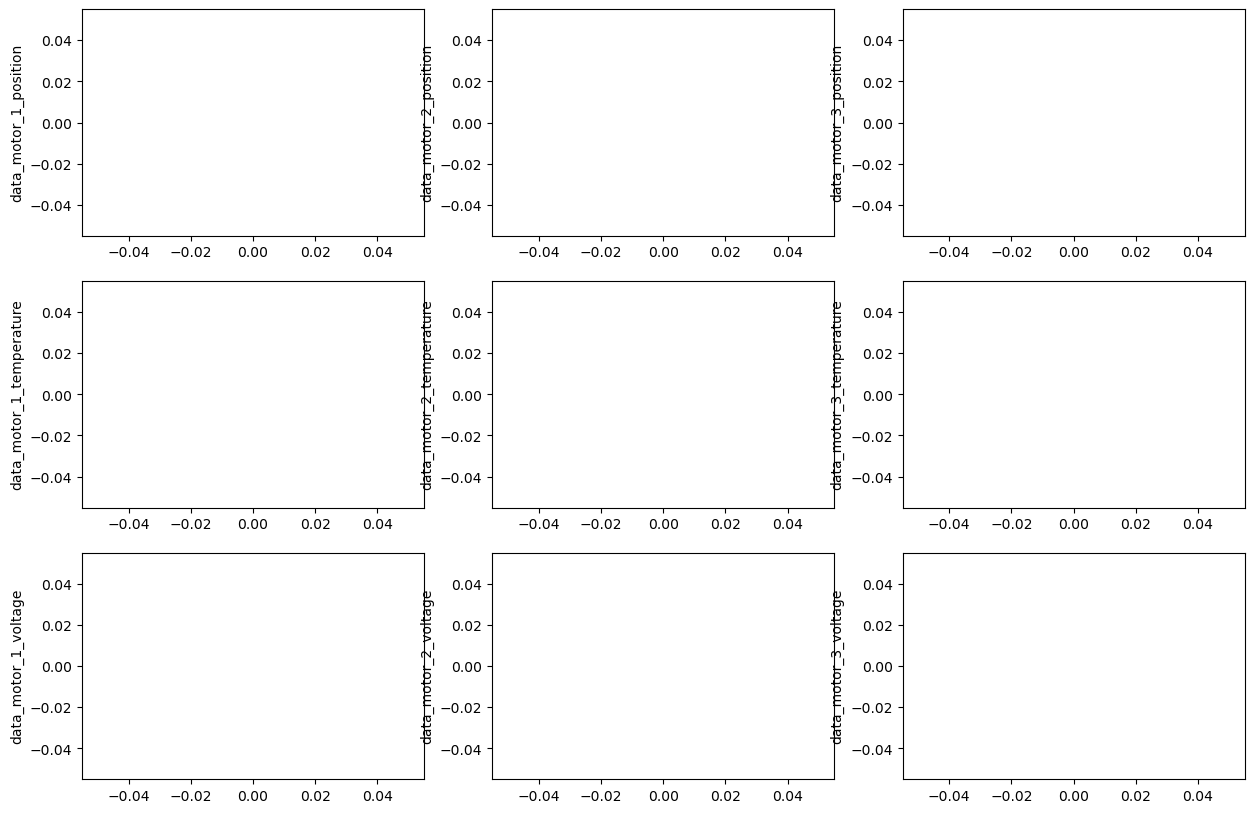

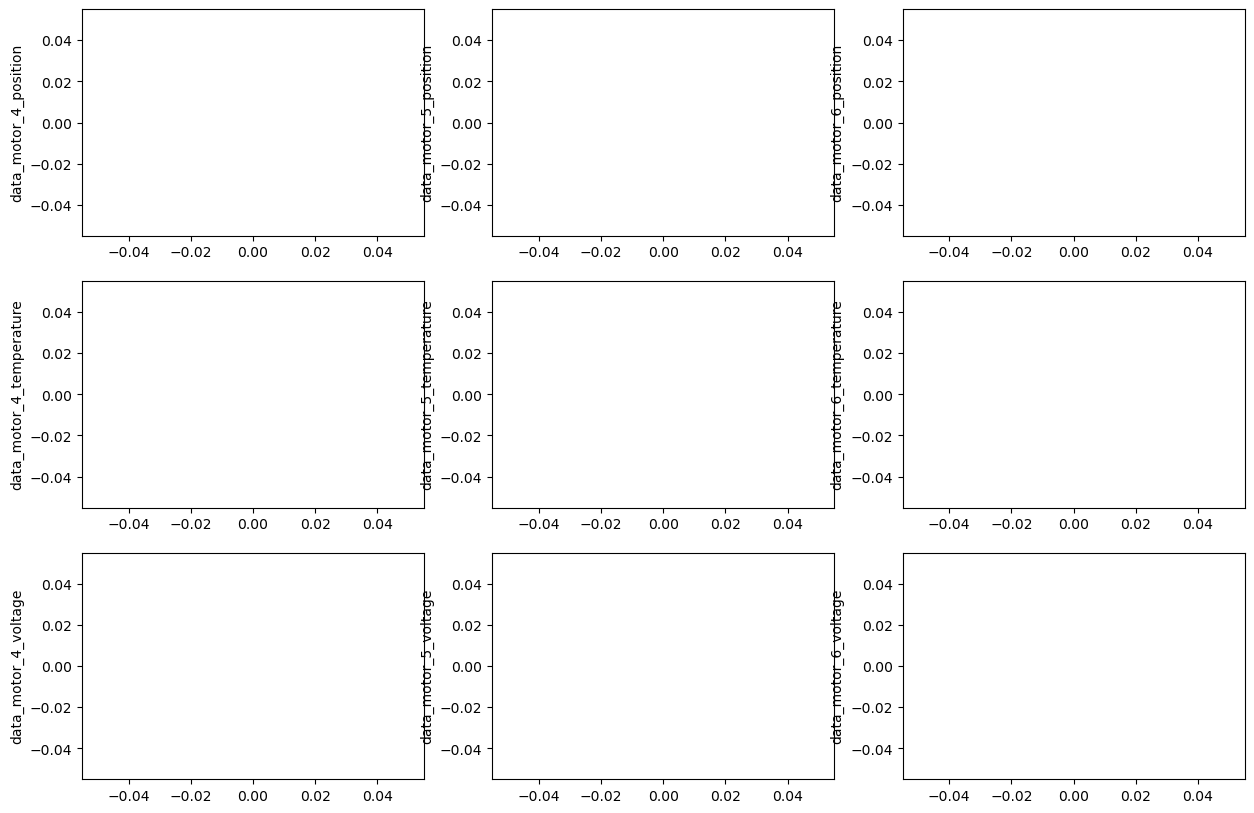

20240527_100759: 1    Transfer goods
Name: Description, dtype: object



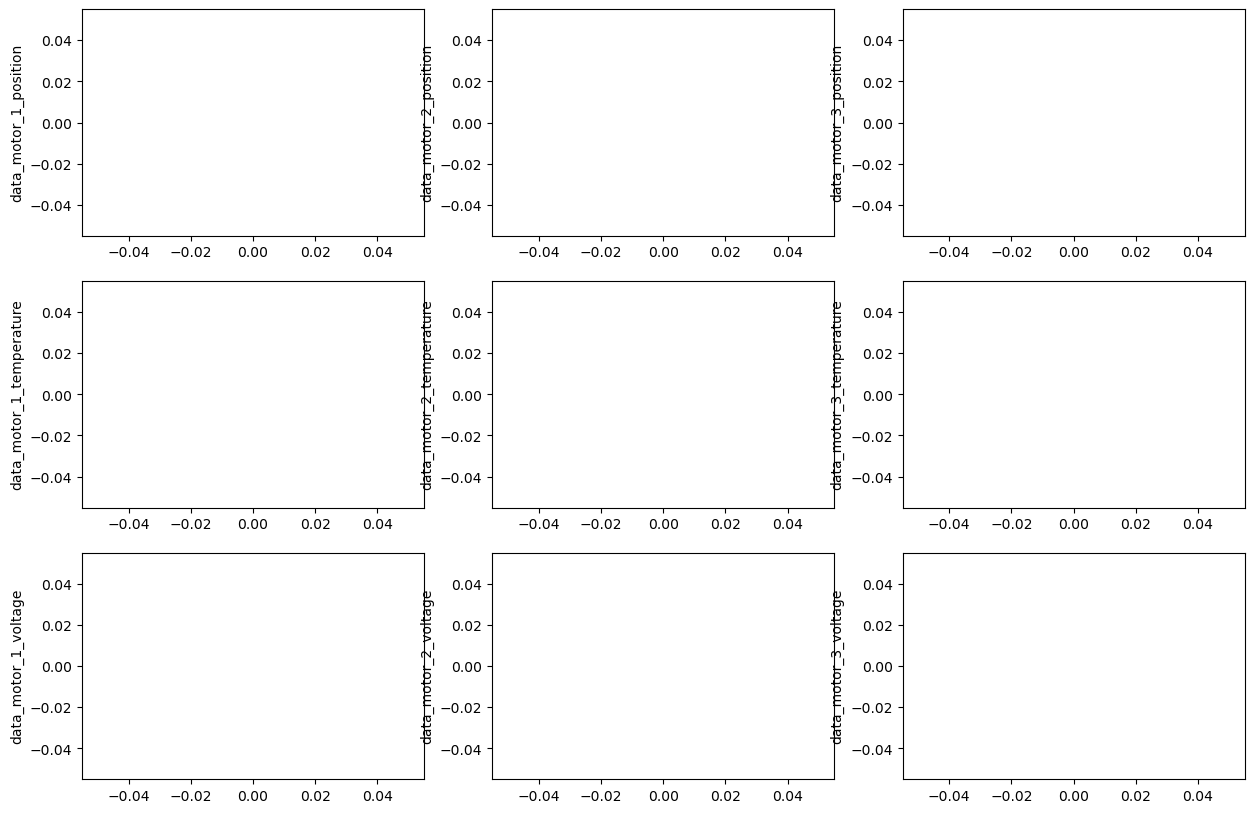

KeyboardInterrupt: 

In [36]:
n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    # Function to design a Butterworth low-pass filter
    def butter_lowpass(cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a


    # Function to apply the Butterworth low-pass filter
    def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
        b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
        filtered_data = filtfilt(b, a, data)
        return filtered_data


    # Set parameters for the low-pass filter
    cutoff_frequency = .8  # Adjust as needed
    sampling_frequency = 10  # Assuming your data is evenly spaced in time


    def customized_outlier_removal(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].ffill()
        df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
        df['position'] = df['position'].rolling(window=20, min_periods=1).mean()
        df['position'] = df['position'].round()

        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].rolling(window=20, min_periods=1).mean()

        # Make sure that the difference between the current and previous temperature cannot be too large.
        # Define your threshold
        threshold = 5
        # Shift the 'temperature' column by one row to get the previous temperature
        prev_tmp = df['temperature'].shift(1)
        # Calculate the absolute difference between current and previous temperature
        temp_diff = np.abs(df['temperature'] - prev_tmp)
        # Set the temperature to NaN where the difference is larger than the threshold
        df.loc[temp_diff > threshold, 'temperature'] = np.nan
        df['temperature'] = df['temperature'].ffill()

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
        df['voltage'] = df['voltage'].ffill()
        df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
        df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df, n_int)

base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, pre_processing)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

base_dictionary_test = '../../ws_group_1/deliverables/testing_data/testing_data/'
df_data_test = read_all_test_data_from_path(base_dictionary_test,pre_processing, is_plot=False)

# Get all the folders in the base_dictionary
path_list_test = os.listdir(base_dictionary_test)
# Only keep the folders, not the excel file.
path_list_test = path_list_test[:-1]

# Read the data.
df_data_smoothing_test = pd.DataFrame()
for tmp_path_test in path_list_test:
    path_test = base_dictionary_test + tmp_path_test
    tmp_df_test = read_all_csvs_one_test(path_test, tmp_path_test, pre_processing)
    df_data_smoothing_test = pd.concat([df_data_smoothing_test, tmp_df_test])
    df_data_smoothing_test = df_data_smoothing_test.reset_index(drop=True)

# Read the test conditions
df_test_test_conditions = pd.read_excel(base_dictionary_test+'Test conditions.xlsx')

In [35]:
df_data_test.describe()

,time,data_motor_1_position,data_motor_1_temperature,data_motor_1_voltage,data_motor_1_label,data_motor_2_position,data_motor_2_temperature,data_motor_2_voltage,data_motor_2_label,data_motor_3_position,...,data_motor_4_voltage,data_motor_4_label,data_motor_5_position,data_motor_5_temperature,data_motor_5_voltage,data_motor_5_label,data_motor_6_position,data_motor_6_temperature,data_motor_6_voltage,data_motor_6_label
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]

feature_list_all_0 = ['time',
                 'data_motor_2_position', 
                'data_motor_3_position', 
                'data_motor_4_position', 'data_motor_3_temperature',
                  'data_motor_6_temperature']

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature','data_motor_1_voltage',
       'data_motor_1_temperature_diff', 'data_motor_1_voltage_diff','data_motor_1_position_diff', 
       'data_motor_2_position','data_motor_2_temperature', 'data_motor_2_voltage', 
       'data_motor_2_temperature_diff', 'data_motor_2_voltage_diff', 'data_motor_2_position_diff',
       'data_motor_3_position', 'data_motor_3_temperature','data_motor_3_voltage',
       'data_motor_3_temperature_diff', 'data_motor_3_voltage_diff','data_motor_3_position_diff', 
       'data_motor_4_position','data_motor_4_temperature', 'data_motor_4_voltage',
       'data_motor_4_temperature_diff', 'data_motor_4_voltage_diff', 'data_motor_4_position_diff',
       'data_motor_5_position', 'data_motor_5_temperature','data_motor_5_voltage',
       'data_motor_5_temperature_diff', 'data_motor_5_voltage_diff','data_motor_5_position_diff', 
       'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
       'data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']

feature_list_all_2 = ['time','data_motor_1_position', 'data_motor_1_temperature',
                'data_motor_2_position', 'data_motor_2_temperature',
                'data_motor_3_position',
                'data_motor_4_temperature',
                'data_motor_5_position', 'data_motor_5_temperature', 
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage','data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']

feature_list_all_3 = ['time','data_motor_1_position', 'data_motor_1_temperature',
                'data_motor_2_position', 'data_motor_2_temperature',
                'data_motor_3_position','data_motor_3_temperature',
                'data_motor_4_temperature','data_motor_4_position',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_6_temperature', 'data_motor_6_voltage']

# Test data.
test_id = [
    '20240527_094865',
    '20240527_100759',
    '20240527_101627',
    '20240527_102436',
    '20240527_102919',
    '20240527_103311',
    '20240527_103690',
    '20240527_104247'
]
df_test = df_data_smoothing_test[df_data_smoothing_test['test_condition'].isin(test_id)]

In [14]:
def evaluate_model(name, steps,param_grid, features, window_size, sample_step, prediction_lead_time, threshold, abnormal_limit, n_fold=7):
    print(f'Running model: {name}')
    
    x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=features, motor_idx=6, mdl_type='reg')
    
    x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')
    
    
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(pipeline, param_grid, cv=n_fold, scoring='f1', n_jobs=-1)
    
    grid_search.fit(x_tr, y_temp_tr)
    best_model = grid_search.best_estimator_
    
    #mdl = Pipeline(steps).fit(x_tr, y_temp_tr)
    
    # Define the fault detector
    detector_reg = FaultDetectReg(reg_mdl=best_model, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)
    
    # # Run cross validation
    n_fold = 7
    _, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=features, motor_idx=6, mdl_type='clf')
    x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=features, motor_idx=6, mdl_type='reg')
    
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    
    motor_idx = 1
    print(f'Model for motor {motor_idx}:')
    
    # Run cross validation.
    df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold,single_run_result=False)
    
    print(f'{name} performance:\n{df_perf}\n')
    print('Mean performance metric and standard error:')
    for metric, error in zip(df_perf.mean(), df_perf.std()):
        print(f'{metric:.4f} +- {error:.4f}')
    print('\n')
    return df_perf

In [15]:
# Enrich the features based on the sliding window.
window_size = 80
sample_step = 60
prediction_lead_time = 5 
threshold = .5
abnormal_limit = 3

#param_grids = {
    #'Linear Regression': [{}],  # Note: GridSearchCV requires at least one parameter grid
    #'Ridge Regression': [{'regressor__alpha': np.logspace(-7, 1, num=100)}],# always choose the lowest value
    #'Lasso Regression': [{'regressor__alpha': np.logspace(-7, 1, num=100)}],# always choose the lowest value
    #'ElasticNet Regression': [{'regressor__alpha': np.logspace(-7, 1, num=100), 'regressor__l1_ratio': np.logspace(-7, 1, num=100)}], # always choose the lowest value
    #'Decision Tree Regression': [{'regressor__max_depth': [2,3,4], 'regressor__min_samples_split': [2,3,4]}] # always choose the lowest value
#}

#fix parameters to run faster, since we already know the best chosen parameters

param_grids = {
    'Linear Regression': [{}],  # Note: GridSearchCV requires at least one parameter grid
    'Ridge Regression': [{'regressor__alpha': [0.00001]}],# always choose the lowest value
    'Lasso Regression': [{'regressor__alpha': [0.00001]}],# always choose the lowest value
    'ElasticNet Regression': [{'regressor__alpha': [0.00001], 'regressor__l1_ratio': [0.00001]}], # always choose the lowest value
    'Decision Tree Regression': [{'regressor__max_depth': [2], 'regressor__min_samples_split': [2]}] # always choose the lowest value
}

results = []
models = [
    ('Linear Regression', [('Normalizer', MinMaxScaler()), ('regressor', LinearRegression())]),
    ('Ridge Regression', [('Normalizer', MinMaxScaler()), ('regressor', Ridge())]),
    ('Lasso Regression', [('Normalizer', MinMaxScaler()), ('regressor', Lasso())]),
    ('ElasticNet Regression', [('Normalizer', MinMaxScaler()), ('regressor', ElasticNet())]),
    ('Decision Tree Regression', [('regressor', DecisionTreeRegressor())])
]

for model_name, model_steps in models:
    param_grid = param_grids[model_name]
    df_perf = evaluate_model(model_name, model_steps,param_grid, feature_list_all, window_size, sample_step, prediction_lead_time, threshold, abnormal_limit)
    mean_perf = df_perf.mean()
    results.append((model_name, mean_perf['Accuracy'], mean_perf['Precision'], mean_perf['Recall'], mean_perf['F1 score']))

table_md = "| Model   | Accuracy | Precision | Recall | F1   |\n"
table_md += "|---------|----------|-----------|--------|------|\n"
for result in results:
    model_name, accuracy, precision, recall, f1 = result
    table_md += f"| {model_name} | {accuracy:.2f} | {precision:.2f} | {recall:.2f} | {f1:.2f} |\n"

print(table_md)

Running model: Linear Regression
Best parameters for Linear Regression: {}
Model for motor 1:


ValueError: Cannot have number of splits n_splits=7 greater than the number of samples: n_samples=0.

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Linear Regression | 0.83 | 0.75 | 0.70 | 0.71 |
| Ridge Regression | 0.83 | 0.75 | 0.70 | 0.71 |
| Lasso Regression | 0.82 | 0.73 | 0.68 | 0.69 |
| ElasticNet Regression | 0.82 | 0.73 | 0.68 | 0.69 |
| Decision Tree Regression | 0.72 | 0.71 | 0.73 | 0.64 |




- Best model : Linear Regression

- window_size = 80

- sample_step = 60

- prediction_lead_time = 5 

- threshold = .5

- abnormal_limit = 2